In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [1]:
# Set seeds to make the experiment more reproducible.
import random
def seed_everything(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed = 0
seed_everything(seed)

NameError: name 'os' is not defined

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define some parameters for the data loader:
BATCH_SIZE = 32
IMG_SIZE = 224

# Path of the dataset
input_path = '/content/drive/MyDrive/Dataset/Paddy_doctor/split5FoldDataset/1/'
train_data_dir = input_path + 'train/'
test_data_dir = input_path + 'test/'

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,shuffle = True)
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,shuffle = True)

class_names = train_ds.class_names
n_classes = len(class_names)
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE
def prepare_dataset(ds):
    def input_preprocess(image, label):
        label = tf.one_hot(label, n_classes)
        return image, label
    ds = ds.map(input_preprocess, num_parallel_calls = AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size = AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds)

Found 8325 files belonging to 10 classes.
Found 2082 files belonging to 10 classes.
['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [ ]:
## mdata augmentasi dan model
data_augmentation = keras.Sequential([
    layers.RandomRotation(factor = 0.1),
    layers.RandomFlip('horizontal'),
    layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
    layers.RandomContrast(factor = 0.1),
])

def create_model(n_classes, fine_tune = 0):
    inputs = layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3))
    x = layers.Rescaling(1.0/255)(inputs)
    x = data_augmentation(x)
    conv_base = tf.keras.applications.VGG16(include_top = False, input_tensor = x, weights = 'imagenet')

    # Freeze the pretrained weights
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name = 'gap')(conv_base.output)
    x = layers.BatchNormalization()(x)

    initializer = tf.keras.initializers.GlorotUniform()
    x = tf.keras.layers.Dense(256, kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer = initializer, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = layers.Dense(n_classes, kernel_initializer = initializer, activation = 'softmax', name = 'pred')(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name = 'VGG16')
    model.compile(
        #optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
        #optimizer = tf.keras.optimizers.Adamax(learning_rate = 1e-3),
        optimizer = tf.keras.optimizers.Nadam(learning_rate = 1e-3),
        #optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-3),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'])

    return model

In [ ]:
model = create_model(n_classes, 2)
model.summary()

58889256/58889256 [==============================] - 4s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
# ModelCheckpoint callback - save best weights
tempatmodel=input_path+"vgg16_best_weights_nadam.hdf5"
tl_checkpoint_1 = ModelCheckpoint(filepath =tempatmodel ,
                                  save_best_only = True,
                                  verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 10,
                           restore_best_weights = True,
                           mode = 'min')

rlrop = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.5,
                          patience = 3,
                          verbose = 1)
epochs = 100
history = model.fit(train_ds,
                    epochs = epochs,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rlrop],
                    batch_size=32,
                    verbose = 2)

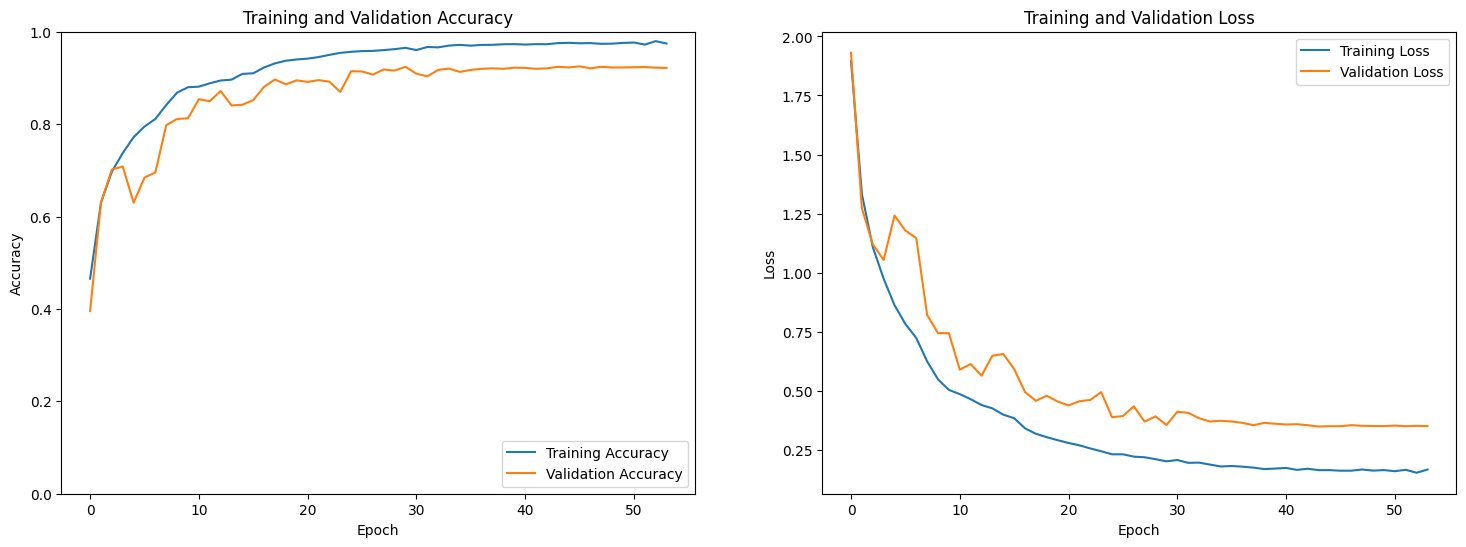

In [ ]:
# mendapatkan hasil akurasi dan loss dari training dan testing
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# evaluate the model
scores = model.evaluate(val_ds, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

66/66 - 218s - loss: 2.6746 - accuracy: 0.0917 - 218s/epoch - 3s/step
accuracy: 9.17%


In [ ]:
# Create a new model instance
model = create_model(n_classes, 2)

# Restore the weights
model.load_weights('/content/drive/MyDrive/Dataset/Paddy_doctor/tempData/5/vgg16_best_weights_adam.hdf5')

# Evaluate the model
val_loss,val_acc = model.evaluate(val_ds)
loss,acc = model.evaluate(train_ds)
print("Restored model, accuracy: {:5.2f}% loss: {:5.2f}%".format(100 * acc,100 * loss))
print("Restored model, vall_accuracy: {:5.2f}% vall_loss: {:5.2f}%".format(100 * val_acc,100 * val_loss))


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


261/261 [==============================] - 835s 3s/step - loss: 0.1208 - accuracy: 0.9816
Restored model, accuracy: 98.16% loss: 12.08%
Restored model, vall_accuracy: 93.66% vall_loss: 31.43%


In [ ]:
# Create a new model instance
model = create_model(n_classes, 2)

# Restore the weights
model.load_weights('/content/drive/MyDrive/Dataset/Paddy_doctor/tempData/5/vgg16_best_weights_adamax.hdf5')

# Evaluate the model
val_loss,val_acc = model.evaluate(val_ds)
loss,acc = model.evaluate(train_ds)
print("Restored model, accuracy: {:5.2f}% loss: {:5.2f}%".format(100 * acc,100 * loss))
print("Restored model, vall_accuracy: {:5.2f}% vall_loss: {:5.2f}%".format(100 * val_acc,100 * val_loss))

261/261 [==============================] - 31s 118ms/step - loss: 0.1823 - accuracy: 0.9855
Restored model, accuracy: 98.55% loss: 18.23%
Restored model, vall_accuracy: 93.56% vall_loss: 35.76%


In [ ]:
# Create a new model instance
model = create_model(n_classes, 2)

# Restore the weights
model.load_weights('/content/drive/MyDrive/Dataset/Paddy_doctor/tempData/5/vgg16_best_weights_nadam.hdf5')

# Evaluate the model
val_loss,val_acc = model.evaluate(val_ds)
loss,acc = model.evaluate(train_ds)
print("Restored model, accuracy: {:5.2f}% loss: {:5.2f}%".format(100 * acc,100 * loss))
print("Restored model, vall_accuracy: {:5.2f}% vall_loss: {:5.2f}%".format(100 * val_acc,100 * val_loss))

261/261 [==============================] - 31s 120ms/step - loss: 0.0913 - accuracy: 0.9879
Restored model, accuracy: 98.79% loss:  9.13%
Restored model, vall_accuracy: 93.42% vall_loss: 28.94%


In [ ]:
# Create a new model instance
model = create_model(n_classes, 2)

# Restore the weights
model.load_weights('/content/drive/MyDrive/Dataset/Paddy_doctor/tempData/5/vgg16_best_weights_sgd.hdf5')

# Evaluate the model
val_loss,val_acc = model.evaluate(val_ds)
loss,acc = model.evaluate(train_ds)
print("Restored model, accuracy: {:5.2f}% loss: {:5.2f}%".format(100 * acc,100 * loss))
print("Restored model, vall_accuracy: {:5.2f}% vall_loss: {:5.2f}%".format(100 * val_acc,100 * val_loss))

261/261 [==============================] - 32s 122ms/step - loss: 1.0601 - accuracy: 0.7731
Restored model, accuracy: 77.31% loss: 106.01%
Restored model, vall_accuracy: 73.09% vall_loss: 114.26%
